In [33]:
import numpy as np 
import gym
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
import pandas as pd
import GPUtil

from gym import Env, spaces

pd.options.display.max_rows = 12

#get a matrix of distances between locations
df = pd.read_csv('dist_vologda_matrix.csv', sep=',')
df = df.iloc[:, 1:]

#some parameters
working_hours = 12
truck_speed = 60

df = df / 1000
df

,АЗС №35400 Кичменгский Городок,АЗС №35401 Великий Устюг-1,АЗС №35402 Великий Устюг-2,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35406 Журавлево,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,99.2272,101.8513,139.2135,154.2522,777.2635,102.4328,520.5020,517.8863,266.7014,...,610.3886,610.3028,607.3283,609.0579,611.0852,611.0605,604.2684,605.7555,502.9826,477.9325
1,99.0684,0.0000,4.9465,134.5201,149.5589,748.0318,5.5280,491.2703,488.6546,241.7276,...,581.1570,581.0711,578.0967,579.8263,581.8535,581.8288,575.0368,576.5238,473.7510,448.7008
2,101.8148,5.0688,0.0000,137.2665,152.3053,750.7781,3.0302,494.0166,491.4010,244.4739,...,583.9033,583.8174,580.8430,582.5726,584.5999,584.5752,577.7831,579.2702,476.4973,451.4472
3,139.2135,134.6791,137.3031,0.0000,15.0961,613.5690,137.8846,356.8075,354.1918,107.2648,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
4,154.2522,149.7178,152.3419,15.0961,0.0000,613.8947,152.9234,357.1332,354.5176,107.5905,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,611.7861,582.6174,585.2414,447.9957,448.3214,191.2351,585.8229,181.8523,179.2367,345.2112,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
60,605.7962,576.6275,579.2515,442.0057,442.3315,185.0682,579.8330,175.8624,173.2467,339.2213,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
61,607.1467,577.9779,580.6020,443.3562,443.6820,186.4186,581.1835,177.2129,174.5972,340.5717,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
62,504.6641,475.4954,478.1194,340.8736,341.1994,274.3706,478.7009,74.7303,72.1146,238.0892,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [34]:
#remove locations, which cannot be served in 12 hours (driver can't get there and come back in 12 hours)
to_remove = ((2 * (df.values[-1,:] / truck_speed) < working_hours) == False).nonzero()[0]
df = df.drop(df.index[to_remove])
df = df.drop(df.columns[to_remove], axis=1)
df = df.reset_index(drop=True)
df

,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,АЗС №35410 Сазоново-1,АЗС №35411 Сазоново-2,АЗС №35412 Вытегра,АЗС №35413 Липник,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,15.0961,613.5690,356.8075,354.1918,107.2648,619.0077,618.5201,629.3182,472.6696,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
1,15.0961,0.0000,613.8947,357.1332,354.5176,107.5905,619.3335,618.8458,629.6440,472.9954,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
2,615.1980,615.5238,0.0000,349.0547,346.4390,512.4135,142.9597,142.4720,165.8965,193.2966,...,187.4480,187.3622,184.7850,188.3816,183.6881,191.1772,185.1426,186.6296,274.4141,309.3918
3,356.1259,356.4516,349.7479,0.0000,3.7018,253.3414,355.1867,354.6990,373.5276,216.8790,...,182.8731,182.7873,179.8128,181.5424,183.5697,183.5450,176.7529,178.2400,75.4671,45.6714
4,353.5507,353.8764,347.1727,3.7422,0.0000,250.7662,352.6115,352.1238,370.9524,214.3038,...,180.2979,180.2120,177.2376,178.9672,180.9945,180.9698,174.1777,175.6648,72.8919,43.0962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,447.9957,448.3214,191.2351,181.8523,179.2367,345.2112,196.6738,196.1861,332.9386,176.2900,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
52,442.0057,442.3315,185.0682,175.8624,173.2467,339.2213,190.5069,190.0192,326.9487,170.3001,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
53,443.3562,443.6820,186.4186,177.2129,174.5972,340.5717,191.8574,191.3697,328.2991,171.6506,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
54,340.8736,341.1994,274.3706,74.7303,72.1146,238.0892,279.8093,279.3216,346.5072,189.8586,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [35]:
from numpy.random import default_rng

#shrink array
#df = df.iloc[40:56,40:56]
rng = default_rng()
idx = [10, 23, 46,  7, 11, 40, 12, 53, 16,  2, 45, 38,  1, 34, 43, 44,  3,
       14, 15, 24, 41, 22, 19, 37, 33, 54, 39,  6, 36,  0, 49,  4, 48, 30,
       50, 27, 17, 18,  9, 21]
print(idx)
df = df.drop(df.index[idx])
df = df.drop(df.columns[idx], axis=1)
df = df.reset_index(drop=True)
N = len(df.values[0])
print(N)
df

[10, 23, 46, 7, 11, 40, 12, 53, 16, 2, 45, 38, 1, 34, 43, 44, 3, 14, 15, 24, 41, 22, 19, 37, 33, 54, 39, 6, 36, 0, 49, 4, 48, 30, 50, 27, 17, 18, 9, 21]
16


,АЗС №35409 Савино,АЗС №35412 Вытегра,АЗС №35417 Барское,АЗС №35427 Марьинское,АЗС №35433 Сокол,АЗС №35434 Верховажье,АЗС №35436 Вожега,АЗС №35437 Харовск,АЗС №35439 Козленская,АЗС №35440 Мудрова,АЗС №35443 Маршала Конева-1,АЗС №35450 Кирилловское шоссе-1,АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,Нефтебаза
0,0.0000,526.3698,183.4339,205.5501,186.5665,122.8875,310.9966,240.3297,210.0147,206.7060,211.7736,338.3356,343.6599,344.4176,337.6256,211.2896
1,528.0211,0.0000,344.4233,321.5271,356.9127,543.2065,509.9042,432.2983,328.4836,328.7171,330.2426,326.7767,332.1010,332.8587,326.0666,329.7586
2,183.5979,342.9359,0.0000,22.1162,12.4894,198.7833,151.0916,87.8750,26.5808,23.2721,28.3397,154.9017,160.2260,160.9837,154.1917,27.8557
3,206.6218,320.8910,23.0239,0.0000,35.5133,221.8072,174.1155,110.8989,14.5443,12.1694,16.3032,132.8568,138.1811,138.9388,132.1468,15.8192
4,186.8042,355.4094,12.4735,34.5897,0.0000,201.9896,138.6263,75.4097,39.0543,35.7457,40.8132,167.3752,172.6995,173.4573,166.6652,40.3292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,339.1860,326.9134,155.5882,132.6920,168.0776,354.3714,306.6797,243.4632,134.8893,135.9759,135.0299,0.0000,6.7514,7.4895,0.6975,136.1642
12,345.3000,333.0274,161.7021,138.8060,174.1915,360.4854,312.7937,249.5771,141.0033,142.0899,141.1438,6.1660,0.0000,9.8063,6.8114,142.2782
13,345.2112,332.9386,161.6133,138.7172,174.1027,360.3966,312.7049,249.4884,140.9145,142.0011,141.0550,7.4471,10.0417,0.0000,6.1623,142.1894
14,339.2213,326.9487,155.6234,132.7272,168.1128,354.4067,306.7150,243.4984,134.9246,136.0112,135.0651,1.4624,6.7867,6.8095,0.0000,136.1995


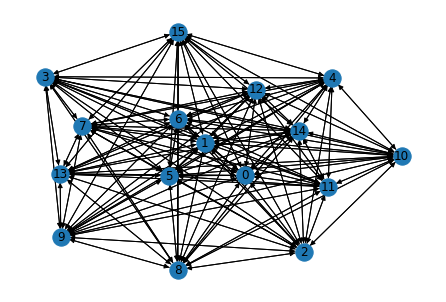

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph)
nx.draw(G, with_labels = True)
plt.show()

In [37]:
#custom gym environment for our problem
m = 5
N = len(df.values[0])
working_hours = 12
truck_speed = 60

class TransportScape(Env):
    def __init__(self, env_config):
        self.num_of_trucks = m
        self.num_of_locations = N
        self.h = working_hours #working hours of each truck driver
        self.speed = truck_speed
        self.distances = df.values #an array, containing distances between locations
    
        self.action_space = spaces.MultiDiscrete([self.num_of_trucks, self.num_of_locations - 1])
    
        self.observation_space = spaces.Dict(
        {
            #x_i - shows each truck's location
            'truck location': spaces.MultiDiscrete(np.full(self.num_of_trucks, self.num_of_locations)),
            #p_j - shows whether a truck is assigned to this particular location or not
            'assignment': spaces.MultiBinary(self.num_of_locations - 1), 
            #u_i - shows whether a particular truck was used before
            'truck usage': spaces.MultiBinary(self.num_of_trucks),
            #delta_i - shows how much time each truck has left until the end of the work day
            'time left': spaces.Box(low=np.zeros(self.num_of_trucks), high=np.full(self.num_of_trucks, self.h), dtype=np.float64)
        })
        self.reset()
        
    def nice_print(self):
        print("Truck Location")
        print(self.state['truck location'])
        print("Assignment")
        print(self.state['assignment'])
        print("Truck Usage")
        print(self.state['truck usage'])
        print("Time Left")
        print(self.state['time left'])
        
    def reset(self):
        self.state = {'truck location': np.full(self.num_of_trucks, self.num_of_locations - 1),
                      'assignment': np.zeros(self.num_of_locations - 1),
                      'truck usage': np.zeros(self.num_of_trucks),
                      'time left': np.full(self.num_of_trucks, self.h)}
        self.done = False
        return self.state 
    
    def step(self, action):
        i, j = action[0], action[1]
        truck_loc = self.state['truck location']
        assignment = self.state['assignment']
        truck_use = self.state['truck usage']
        time_left = self.state['time left']
        
        #if a truck is already assigned to this location - penalty
        if assignment[j] == 1:
            self.reward = -6000
        #if no time left - penalty
        elif (time_left[i] - self.distances[truck_loc[i], j] / self.speed - self.distances[j, -1] / self.speed) < 0:
            self.reward = -6000
        #else - assign truck to a new location
        else:
            self.reward = 0
            #print("else")
            #if needs to use an unused before truck - penalty
            if truck_use[i] == 0:
                self.reward = -2000
                truck_use[i] = 1
            assignment[j] = 1
            self.reward -= self.distances[truck_loc[i], j]
            time_left[i] -= self.distances[truck_loc[i], j] / self.speed - 0.5
            truck_loc[i] = j
        #if all locations have trucks assigned to them - end episode
        if np.all(assignment == 1):
            self.done = True
        else:
            self.done = False
        
        self.state['truck location'] = truck_loc
        self.state['assignment'] = assignment
        self.state['truck usage'] = truck_use
        self.state['time left'] = time_left
        
        return self.state, self.reward, self.done, {}

In [38]:
config = ppo.DEFAULT_CONFIG.copy()
config["num_workers"] = 8
config["framework"] = "torch"
#config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['kl_coeff'] = 0.0 #можно поменять
config["log_level"] = "ERROR"
config["env_config"] = {}
config["clip_param"] = 0.3
config["entropy_coeff"] = 0.01
config['lr'] = 0.0001
config["horizon"] = N #numbers of t_steps after which termiate
config["train_batch_size"] = 4000 
config["rollout_fragment_length"] = 500 # batch_size per worker

In [39]:
ray.shutdown()
ray.init()

2022-06-07 17:26:42,004	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.76', 'raylet_ip_address': '192.168.1.76', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-07_17-26-40_008582_956575/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-07_17-26-40_008582_956575/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-06-07_17-26-40_008582_956575', 'metrics_export_port': 60362, 'gcs_address': '192.168.1.76:55587', 'address': '192.168.1.76:55587', 'node_id': '57b72ccf67fd2c643b6e310015db21fa3a564daf172a3850652baeb4'})

In [40]:
agent = ppo.PPOTrainer(config=config, env=TransportScape)

In [41]:
import datetime
start = datetime.datetime.now()
print(start)

for i in range(1001):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        checkpoint = agent.save()
finish = datetime.datetime.now()
print(finish)
duration = finish - start
print("Total Hours: ", duration.total_seconds() / 3600)

2022-06-07 17:26:50.285156
i:  0
mean episode length: 16.0
max episode reward: -36191.1278
mean episode reward: -52500.83214314516
min episode reward: -71030.82879999999
total episodes: 248
i:  10
mean episode length: 16.0
max episode reward: -29708.4469
mean episode reward: -47415.90452298387
min episode reward: -66644.3814
total episodes: 2744
i:  20
mean episode length: 16.0
max episode reward: -28933.400999999998
mean episode reward: -40985.422756048385
min episode reward: -59505.0848
total episodes: 5248
i:  30
mean episode length: 16.0
max episode reward: -18227.8935
mean episode reward: -35129.14920887097
min episode reward: -55133.0061
total episodes: 7744
i:  40
mean episode length: 15.995967741935484
max episode reward: -11920.4679
mean episode reward: -31475.31394596774
min episode reward: -53510.5683
total episodes: 10248
i:  50
mean episode length: 15.991935483870968
max episode reward: -11938.3088
mean episode reward: -29920.094252822582
min episode reward: -56612.0401
to

i:  470
mean episode length: 15.275862068965518
max episode reward: -7359.7752
mean episode reward: -15617.507806130267
min episode reward: -59288.052599999995
total episodes: 122852
i:  480
mean episode length: 15.128787878787879
max episode reward: -7358.1116
mean episode reward: -11586.319129545456
min episode reward: -65440.9057
total episodes: 125491
i:  490
mean episode length: 15.075187969924812
max episode reward: -7357.6947
mean episode reward: -9868.562973308271
min episode reward: -53749.8892
total episodes: 128141
i:  500
mean episode length: 15.109848484848484
max episode reward: -7264.018599999999
mean episode reward: -10536.301021969697
min episode reward: -53372.453
total episodes: 130779
i:  510
mean episode length: 15.079545454545455
max episode reward: -7361.1918000000005
mean episode reward: -10008.951708333334
min episode reward: -51004.6896
total episodes: 133427
i:  520
mean episode length: 15.094696969696969
max episode reward: -7264.018599999999
mean episode re

i:  920
mean episode length: 15.132575757575758
max episode reward: -7175.457300000001
mean episode reward: -11220.978042045457
min episode reward: -44984.8204
total episodes: 241827
i:  930
mean episode length: 15.067415730337078
max episode reward: -7178.100000000001
mean episode reward: -9082.495558052435
min episode reward: -37047.3903
total episodes: 244468
i:  940
mean episode length: 15.117424242424242
max episode reward: -7179.475100000001
mean episode reward: -10518.406016666668
min episode reward: -56969.835399999996
total episodes: 247113
i:  950
mean episode length: 15.140151515151516
max episode reward: -7181.492500000002
mean episode reward: -12439.78443257576
min episode reward: -68334.7278
total episodes: 249763
i:  960
mean episode length: 15.034090909090908
max episode reward: -7183.710800000002
mean episode reward: -8843.825684469697
min episode reward: -45303.41160000001
total episodes: 252402
i:  970
mean episode length: 15.026315789473685
max episode reward: -7180

In [42]:
env = TransportScape(config)
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

action: [1 8]; reward: 0
action: [0 2]; reward: -2001.7317
action: [0 1]; reward: -2027.8231
action: [ 1 13]; reward: -342.9359
action: [ 1 14]; reward: -142.2428
action: [ 1 12]; reward: -6.1623
action: [ 1 11]; reward: -6.7867
action: [ 1 10]; reward: -6.166
action: [1 9]; reward: -135.0299
action: [1 3]; reward: -9.016200000000001
action: [1 5]; reward: -12.815299999999999
action: [3 4]; reward: -221.80720000000002
action: [3 7]; reward: -2040.3125
action: [3 6]; reward: -75.4097
action: [3 0]; reward: -70.6969
Final state:
Assignment: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Trucks used: [1. 1. 0. 1. 0.]
Time left [ 6  4 12  4 12]
-7410.0968


In [43]:
truck_paths = {}
for k, v in actions:
    truck_paths.setdefault(k,[]).append(v)
for k in truck_paths:
    print("Truck #{:}: {:}".format(k,truck_paths[k]))

Truck #1: [8, 13, 14, 12, 11, 10, 9, 3, 5]
Truck #0: [2, 1]
Truck #3: [4, 7, 6, 0]


In [44]:
def GetLength(route):
    length = df.values[-1, route[0]]
    for i in range(1, len(route)):
        length += df.values[route[i-1], route[i]]
    length += df.values[route[-1], -1]
    
    return length

In [45]:
dist = 0
for k in truck_paths:
    dist += GetLength(truck_paths[k])
dist

2177.7698

In [46]:
for k in truck_paths:
    print(GetLength(truck_paths[k]) / truck_speed)

12.806381666666669
11.675293333333334
11.814488333333335
